In [1]:
!nvidia-smi

Fri Nov 29 08:19:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   41C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Importing libraries
# Importing libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, ops
from keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [4]:
base_dir = 'https://console.cloud.google.com/storage/browser/admri-bucket?project=myproject2-437608'

In [5]:
from google.cloud import storage

# Initialize the storage client
client = storage.Client()

# Access your bucket
bucket_name = 'admri-bucket'
bucket = client.get_bucket(bucket_name)

In [6]:

categories = ['CN', 'EMCI', 'MCI', 'LMCI', 'AD']
IMAGE_SIZE = 256
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1)
NUM_CLASSES = 5

# Function to load and preprocess images from GCP bucket
def load_images_from_bucket(bucket, categories):
    data = []
    labels = []
    for category in categories:
        class_num = categories.index(category)
        # Prefix for the image folder in the bucket
        prefix = f'{category}/'
        blobs = bucket.list_blobs(prefix=prefix)  # List all the images in the category folder

        for blob in blobs:
            try:
                # Download the image as bytes
                img_data = blob.download_as_bytes()
                # Decode the image
                img_array = tf.image.decode_image(img_data, channels=1)
                img_array = tf.image.resize(img_array, [IMAGE_SIZE, IMAGE_SIZE])
                img_array = tf.keras.preprocessing.image.img_to_array(img_array)
                data.append(img_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {blob.name}: {e}")
    return np.array(data), np.array(labels)


# Loading data from GCP bucket
x_full, y_full = load_images_from_bucket(bucket, categories)
x_full, y_full = shuffle(x_full, y_full)

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.15, random_state=42)

In [7]:
# Shape of x_train, y_train, x_test, y_test

print(f"x_full shape: {x_full.shape} - y_full shape: {y_full.shape}")
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_full shape: (14000, 256, 256, 1) - y_full shape: (14000,)
x_train shape: (11900, 256, 256, 1) - y_train shape: (11900,)
x_test shape: (2100, 256, 256, 1) - y_test shape: (2100,)


In [8]:
def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), IMAGE_SIZE, IMAGE_SIZE, 1))
    return array

In [9]:
# Normalizing and reshaping the data

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [10]:
# Configuring Hyperparameters

INPUT_SHAPE = (256, 256, 1)

# Augmentation
IMAGE_SIZE = 256
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# Optimizer
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# Training
EPOCHS = 400
BATCH_SIZE = 256
BUFFER_SIZE = 512

# Architecture
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

In [11]:
# Data augmentation

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)


In [12]:
# Implementing Shifted Patch Tokenization

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patch embed the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)


In [13]:
# Implementing the positional embedding on encoded patches

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


In [14]:
# Implementing Multi-Head Self Attention function - locally inside the Vit Transfomer Encoder

class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # The initial value is the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


In [15]:
# Implementing the MLP function - for Transformer Encoder and final classifier

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Building the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)


In [16]:
# Defining the function for the ViT classifier

def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)

    augmented = data_augmentation(inputs)       # Augmenting data

    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)      # Creating patches

    encoded_patches = PatchEncoder()(tokens)        # Encoding patches with positions

    # Create multiple layers of the Transformer block
    for _ in range(TRANSFORMER_LAYERS):

        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)   # Layer normalization 1

        # Creating a multi-head attention layer
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Creating a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Adding MLP
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)

    # Dense layer for classifying outputs
    logits = layers.Dense(NUM_CLASSES)(features)

    # Creating the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)

    return model


In [17]:
# Creating the ViT classifier and Compiling the model

vit = create_vit_classifier(vanilla=False)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

vit.compile(
        optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

In [18]:
# Training the ViT with x_train

history = vit.fit(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
)

Epoch 1/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 60s 744ms/step - accuracy: 0.2143 - loss: 5.4404 - val_accuracy: 0.2286 - val_loss: 1.6007
Epoch 2/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 698ms/step - accuracy: 0.2299 - loss: 1.6323 - val_accuracy: 0.2664 - val_loss: 1.5842
Epoch 3/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 699ms/step - accuracy: 0.2356 - loss: 1.6097 - val_accuracy: 0.2588 - val_loss: 1.5873
Epoch 4/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 699ms/step - accuracy: 0.2249 - loss: 1.6015 - val_accuracy: 0.2471 - val_loss: 1.5743
Epoch 5/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 699ms/step - accuracy: 0.2316 - loss: 1.6024 - val_accuracy: 0.2916 - val_loss: 1.5393
Epoch 6/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 699ms/step - accuracy: 0.2443 - loss: 1.5947 - val_accuracy: 0.2723 - val_loss: 1.5521
Epoch 7/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 699ms/step - accuracy: 0.2422 - loss: 1.5932 - val_accuracy: 0.2941 - val_loss: 1.5319
Epoch 8/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 698ms/step - accuracy: 0.2353 - loss: 1.5860 - 

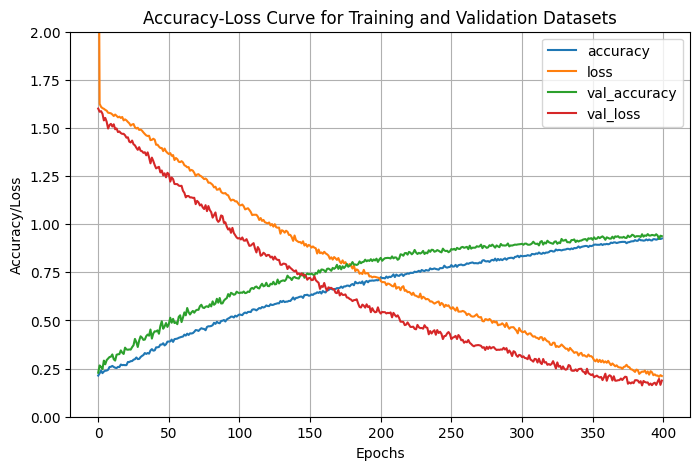

In [19]:
# Accuracy/Loss Curve
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.title('Accuracy-Loss Curve for Training and Validation Datasets')
plt.show()

In [20]:
# Evaluating the model on the test set

# Accuracy and loss for the test dataset
test_loss, test_acc = vit.evaluate(x_test, y_test)

print('\nAccuracy for Test Dataset: %.4f' % test_acc)
print('\nLoss for Test Dataset: %.4f' % test_loss)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9348 - loss: 0.1917

Accuracy for Test Dataset: 0.9367

Loss for Test Dataset: 0.1822


In [21]:
# Getting predictions for test data (getting the highest probability class)

y_pred_probs = vit.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=-1)

66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step



Classification Report: 
               precision    recall  f1-score   support

          CN       0.96      0.92      0.94       440
        EMCI       0.93      0.94      0.93       407
         MCI       0.91      0.95      0.93       391
        LMCI       0.92      0.96      0.94       431
          AD       0.96      0.92      0.94       431

    accuracy                           0.94      2100
   macro avg       0.94      0.94      0.94      2100
weighted avg       0.94      0.94      0.94      2100



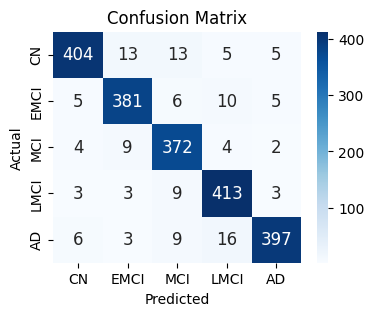

In [22]:
# Classification report
print("\nClassification Report: \n", classification_report(y_test, y_pred, target_names=categories))

# # Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12}, xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

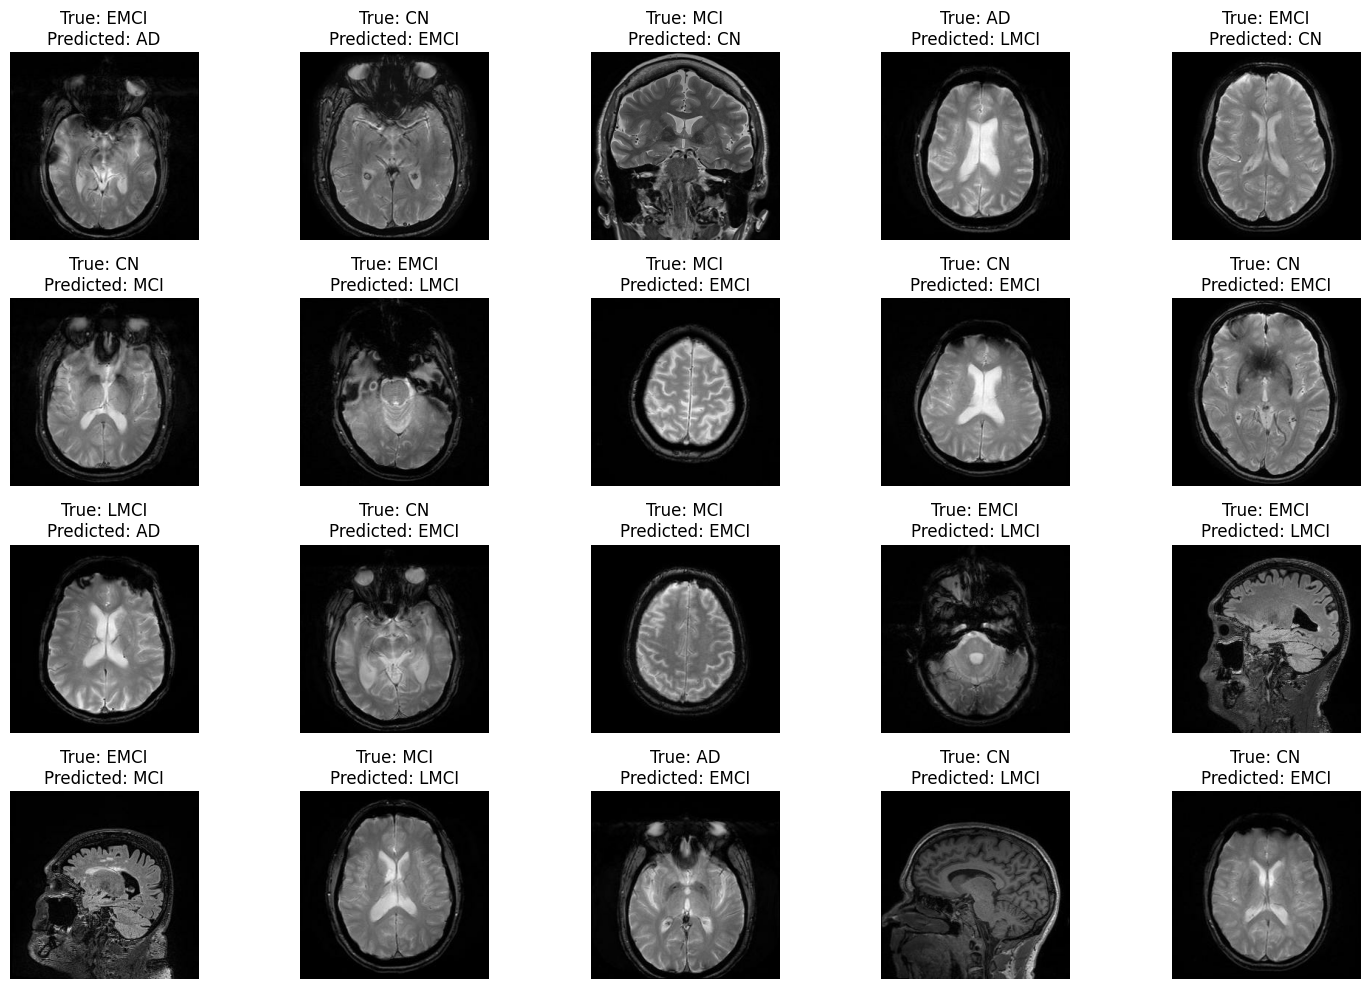

In [23]:
# Displaying the first 20 incorrect predictions

# Finding indices of incorrect predictions
incorrect_indices = np.where(y_pred != y_test)[0]

# Displaying the incorrect predictions
num_incorrect_to_display = min(20, len(incorrect_indices))

plt.figure(figsize=(15, 10))
for i, incorrect_idx in enumerate(incorrect_indices[:num_incorrect_to_display]):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_test[incorrect_idx])
    plt.gray()
    plt.title(f"True: {categories[y_test[incorrect_idx]]}\nPredicted: {categories[y_pred[incorrect_idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
vit.save('trained_models/ViT.keras')

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# This converts y_test to a one-hot encoding
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

# Calculate AUC for each class
auc_values = []
for i in range(y_test_binarized.shape[1]):
    auc = roc_auc_score(y_test_binarized[:, i], y_pred_probs[:, i])
    auc_values.append(auc)

# Display per-class AUC
for class_idx, auc in enumerate(auc_values):
    print(f"AUC for class {class_idx}: {auc:.4f}")

# Optionally calculate the macro-average AUC
macro_auc = np.mean(auc_values)
print(f"Macro-average AUC: {macro_auc:.4f}")

AUC for class 0: 0.9896
AUC for class 1: 0.9901
AUC for class 2: 0.9907
AUC for class 3: 0.9892
AUC for class 4: 0.9887
Macro-average AUC: 0.9897


In [26]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC and AUC for the model
fpr_a, tpr_a, _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
auc_a = auc(fpr_a, tpr_a)

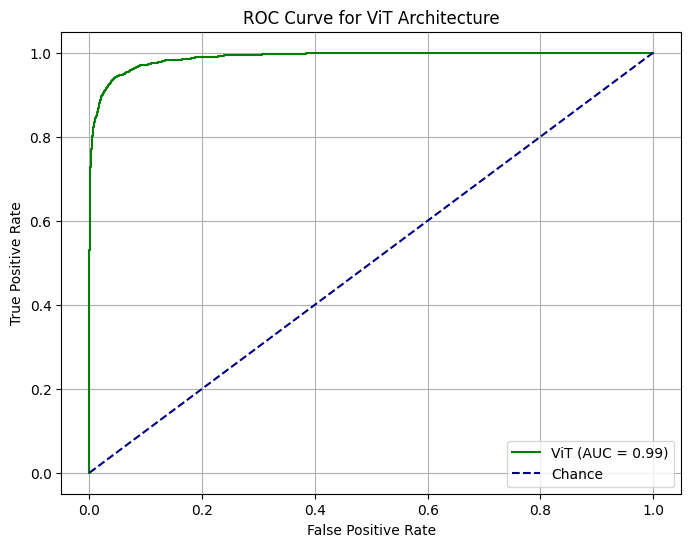

In [27]:
# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_a, tpr_a, color="green", label=f"ViT (AUC = {auc_a:.2f})")

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label="Chance")

# Add labels, legend, and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for ViT Architecture")
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Initialize lists to store results
sensitivity = []
specificity = []

# Calculate metrics for each class
for i in range(len(categories)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)

    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity.append(sens)
    specificity.append(spec)

# Display results
for idx, category in enumerate(categories):
    print(f"{category} - Sensitivity: {sensitivity[idx]:.2f}, Specificity: {specificity[idx]:.2f}")

CN - Sensitivity: 0.92, Specificity: 0.99
EMCI - Sensitivity: 0.94, Specificity: 0.98
MCI - Sensitivity: 0.95, Specificity: 0.98
LMCI - Sensitivity: 0.96, Specificity: 0.98
AD - Sensitivity: 0.92, Specificity: 0.99
